<a href="https://colab.research.google.com/github/Amrutha-murthi/AIRL/blob/main/q2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# CLIPSeg + SAM 2 dependencies
!pip install -q git+https://github.com/facebookresearch/segment-anything.git
!pip install -q transformers timm opencv-python matplotlib



  Preparing metadata (setup.py) ... done


In [ ]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from segment_anything import sam_model_registry, SamPredictor
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation


In [ ]:
!wget -O sample_image.jpg "https://images.unsplash.com/photo-1508214751196-bcfd4ca60f91?ixlib=rb-4.0.3&auto=format&fit=crop&w=800&q=80"


--2025-10-04 11:51:45--  https://images.unsplash.com/photo-1508214751196-bcfd4ca60f91?ixlib=rb-4.0.3&auto=format&fit=crop&w=800&q=80
Resolving images.unsplash.com (images.unsplash.com)... 151.101.2.208, 151.101.66.208, 151.101.130.208, ...
Connecting to images.unsplash.com (images.unsplash.com)|151.101.2.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68620 (67K) [image/jpeg]
Saving to: ‘sample_image.jpg’

sample_image.jpg    100%[===================>]  67.01K  --.-KB/s    in 0.009s  

2025-10-04 11:51:45 (7.27 MB/s) - ‘sample_image.jpg’ saved [68620/68620]



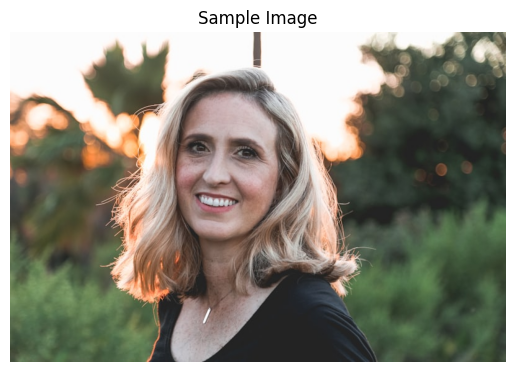

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

image_path = "sample_image.jpg"
image = Image.open(image_path).convert("RGB")

plt.imshow(image)
plt.axis('off')
plt.title("Sample Image")
plt.show()


In [ ]:
# For transformers and CLIPSeg
!pip install transformers ftfy

# Install segment anything (SAM) official package
!pip install git+https://github.com/facebookresearch/segment-anything.git

# (Optional) torch if not installed
!pip install torch torchvision


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.4 MB/s eta 0:00:00
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-0k1j8feo
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-0k1j8feo
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done


In [ ]:
!wget -q --show-progress https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth


sam_vit_h_4b8939.pt 100%[===================>]   2.39G   162MB/s    in 24s     


In [ ]:
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation
import torch
from segment_anything import sam_model_registry, SamPredictor
import numpy as np

# Load CLIPSeg processor and model
clipseg_processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
clipseg_model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined").to("cuda")

# Load SAM model (using SAM_VIT_H here as example)
sam_checkpoint = "sam_vit_h_4b8939.pth"  # You need to upload this checkpoint file in Colab or get it from SAM repo
sam_model_type = "vit_h"
sam = sam_model_registry[sam_model_type](checkpoint=sam_checkpoint)
sam.to(device="cuda")
sam_predictor = SamPredictor(sam)


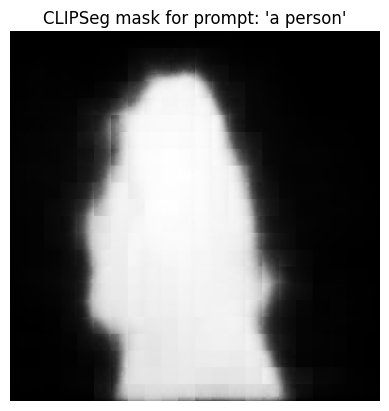

Seed point for SAM: [[161 211]]


In [ ]:
prompt = "a person"  # Change this prompt as you like

inputs = clipseg_processor(text=prompt, images=image, return_tensors="pt").to("cuda")
with torch.no_grad():
    outputs = clipseg_model(**inputs)

logits = outputs.logits  # (batch, H, W)
mask = torch.sigmoid(logits)[0].cpu().numpy()

import matplotlib.pyplot as plt

plt.imshow(mask, cmap="gray")
plt.title(f"CLIPSeg mask for prompt: '{prompt}'")
plt.axis("off")
plt.show()

# Threshold mask and get center of mass as seed point for SAM
threshold = 0.5
binary_mask = (mask > threshold).astype(np.uint8)

if binary_mask.sum() == 0:
    raise ValueError("No segmentation region found, try a different prompt.")

ys, xs = np.where(binary_mask == 1)
input_point = np.array([[int(xs.mean()), int(ys.mean())]])
input_label = np.array([1])
print("Seed point for SAM:", input_point)


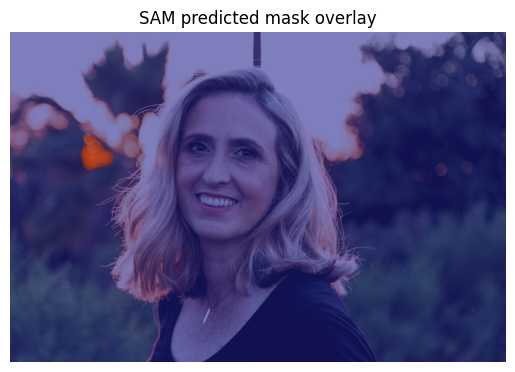

In [ ]:
# Set SAM predictor input image and points
sam_predictor.set_image(np.array(image))

masks, scores, logits = sam_predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=False,
)

mask_sam = masks[0]

plt.imshow(np.array(image))
plt.imshow(mask_sam, alpha=0.5, cmap="jet")
plt.title("SAM predicted mask overlay")
plt.axis("off")
plt.show()
